<a href="https://colab.research.google.com/github/NguyenHoangLongVNUK/detection_cnn_raytune/blob/main/(Torch)Pneumonia_detection_CNN_RayTune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive and connect to working Drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
dir_path = '/content/drive/MyDrive/Year_4/Advanced Data Analytics/CNN'
os.chdir(dir_path)
os.listdir()

['val',
 'test',
 'train',
 'Torch tutorial - cifar10_tutorial.ipynb',
 'cnns-pt2.html',
 '(Keras)Pneumonia_detection_CNN.ipynb',
 'model',
 'Copy of hyperparameter_tuning_tutorial.ipynb',
 '(Torch)Pneumonia_detection_CNN.ipynb']

## Import libraries

In [ ]:
# PyTorch collections
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import transforms, datasets, models
from torchsummary import summary
from torch import cuda
from torch.utils.data import DataLoader, sampler
import torch.utils.model_zoo as model_zoo

# Data science tools
import numpy as np
import pandas as pd
import seaborn as sns
import time
import random

# Image
from PIL import Image

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
# set the font size in plots to 14
plt.rcParams['font.size'] = 14

## Data processing

The `data_transforms` variable is a `Compose` object that applies a series of transformations to the images. The Resize transformation resizes the images to the size specified by `IMAGE_SIZE`, which is a tuple of (150, 150). The `ToTensor` transformation converts the images to PyTorch tensors, and the `Grayscale` transformation converts the images to grayscale.

**For Augmentation:**  
The `RandomVerticalFlip` transformation randomly flips the image vertically with a probability of 0.5. The `RandomRotation` transformation randomly rotates the image by a specified number of degrees (in this case, 20).

`torchvision.datasets.ImageFolder` is a class in the `torchvision.datasets` module that provides an easy way to load image data from a directory. The `root` parameter specifies the path to the directory containing the images.

In [ ]:
IMAGE_SIZE = (150,150)

data_transforms = transforms.Compose([
    transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(degrees=180), # rotate images with random angle from -180 to 180 degrees
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Grayscale()
])

train_dataset = datasets.ImageFolder(root=os.path.join(dir_path,'train'),
                                                 transform=data_transforms)

# transform for valid and test need less modification
test_valid_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Grayscale()
])

valid_dataset = datasets.ImageFolder(root=os.path.join(dir_path,'val'),
                                                 transform=test_valid_transforms)
test_dataset = datasets.ImageFolder(root=os.path.join(dir_path,'test'),
                                                 transform=test_valid_transforms)

In [ ]:
print(f"--- Train Dataset ---")
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)}")
print(f"Samples:",len(train_dataset))
print(f"First sample: {train_dataset.samples[0]}")
print("\n")

print(f"--- Valid Dataset ---")
print(f"Classes: {valid_dataset.classes}")
print(f"Class count: {valid_dataset.targets.count(0)}, {valid_dataset.targets.count(1)}")
print(f"Samples:",len(valid_dataset))
print(f"First sample: {valid_dataset.samples[0]}")
print("\n")

print(f"--- Test Dataset ---")
print(f"Classes: {test_dataset.classes}")
print(f"Class count: {test_dataset.targets.count(0)}, {test_dataset.targets.count(1)}")
print(f"Samples:",len(test_dataset))
print(f"First sample: {test_dataset.samples[0]}")

--- Train Dataset ---
Classes: ['NORMAL', 'PNEUMONIA']
Class count: 1100, 1020
Samples: 2120
First sample: ('/content/drive/MyDrive/Year_4/Advanced Data Analytics/CNN/train/NORMAL/IM-0115-0001.jpeg', 0)


--- Valid Dataset ---
Classes: ['NORMAL', 'PNEUMONIA']
Class count: 58, 58
Samples: 116
First sample: ('/content/drive/MyDrive/Year_4/Advanced Data Analytics/CNN/val/NORMAL/NORMAL2-IM-0319-0001.jpeg', 0)


--- Test Dataset ---
Classes: ['NORMAL', 'PNEUMONIA']
Class count: 184, 340
Samples: 524
First sample: ('/content/drive/MyDrive/Year_4/Advanced Data Analytics/CNN/test/NORMAL/IM-0001-0001.jpeg', 0)


### View loaded images

Text(0.5, 1.0, 'PNEUMONIA')

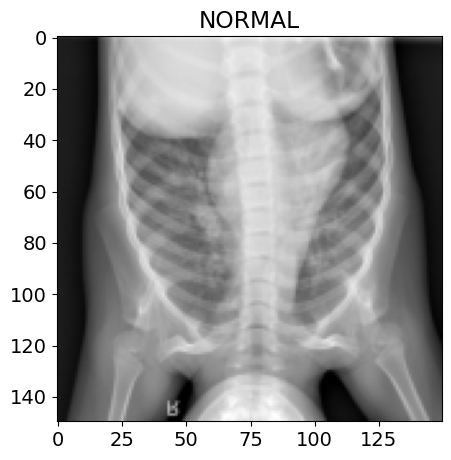

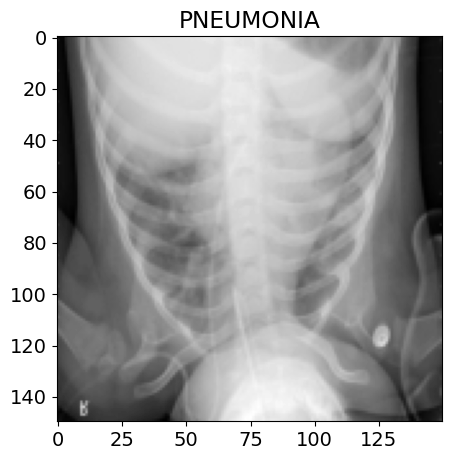

In [ ]:
# output 1 sample of each class - TRAIN

plt.figure(figsize=(5,5))
plt.imshow(train_dataset[0][0].squeeze(), cmap='gray')
plt.title(train_dataset.classes[train_dataset[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(train_dataset[-1][0].squeeze(), cmap='gray')
plt.title(train_dataset.classes[train_dataset[-1][1]])

Text(0.5, 1.0, 'PNEUMONIA')

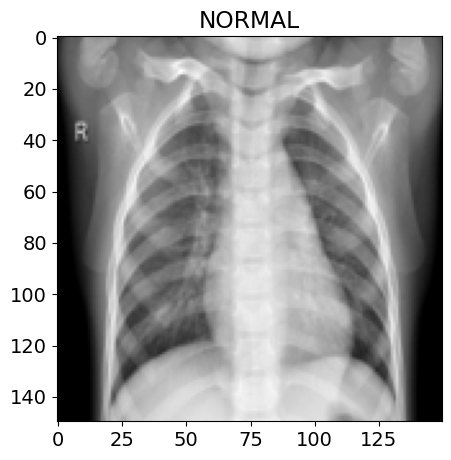

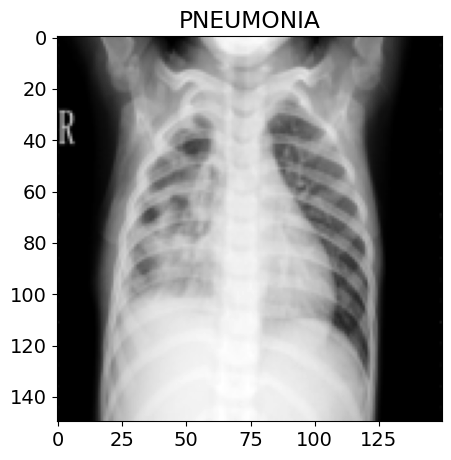

In [ ]:
# output 1 sample of each class - VALID

plt.figure(figsize=(5,5))
plt.imshow(valid_dataset[0][0].squeeze(), cmap='gray')
plt.title(valid_dataset.classes[valid_dataset[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(valid_dataset[-1][0].squeeze(), cmap='gray')
plt.title(valid_dataset.classes[valid_dataset[-1][1]])

Text(0.5, 1.0, 'PNEUMONIA')

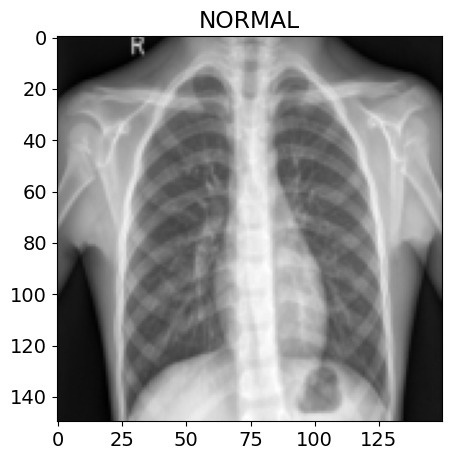

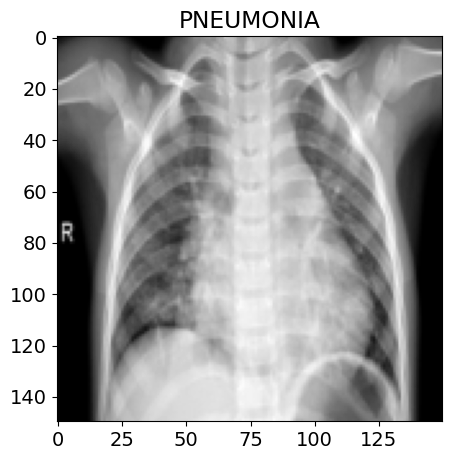

In [ ]:
# output 1 sample of each class - TEST

plt.figure(figsize=(5,5))
plt.imshow(test_dataset[0][0].squeeze(), cmap='gray')
plt.title(test_dataset.classes[test_dataset[0][1]])

plt.figure(figsize=(5,5))
plt.imshow(test_dataset[-1][0].squeeze(), cmap='gray')
plt.title(test_dataset.classes[test_dataset[-1][1]])

### DataLoader: Load dataset to batches

the `DataLoader` class from the `torch.utils.data` module is used to create iterable objects that can be used to load the data in batches during training and validation.

The `train_loader` object is created using the `DataLoader` class with the `train_dataset` object as the first argument. The `batch_size` parameter specifies the number of samples per batch, which is set to 32. The `shuffle` parameter is set to True, which means that the data will be shuffled before each epoch. The `drop_last` parameter is set to False, which means that the last batch will not be dropped even if it is smaller than the batch size.

**The batch size for the validation dataset is usually larger than that of the training dataset.**   

This is because the validation step is usually very fast, so you don’t lose much by picking a suboptimal batch size. In contrast, the batch size for the training dataset should be chosen carefully to balance the trade-off between training speed and convergence.

In general, it’s worth picking a batch size that is neither too small nor too large for the training dataset. For some applications, using the largest possible training batches can actually be desirable, but in general, you select it through experiments and validation.

For the validation dataset, you should pick the largest batch size that your hardware can handle without running out of memory and crashing.

In [ ]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           drop_last=False)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           drop_last=False)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=BATCH_SIZE * 2,
                                           shuffle=True,
                                           drop_last=False)

The resulting `imgs` variable contains a tensor of shape `(batch_size, channels, height, width)` that represents the batch of images, where `batch_size` is the number of images in the batch, `channels` is the number of color channels in the images (usually 3 for RGB images), and `height` and `width` are the dimensions of the images. The targets variable contains a tensor of shape `(batch_size,)` that represents the labels for the images in the batch.

In [ ]:
imgs, targets = next(iter(train_loader))
print(f"       # of batches: {len(train_loader)}")
print(f"    Image data type: {type(imgs)}")
print(f"   Image batch size: {imgs.shape} = (batch_size, channels, height, width)")
print(f"  Target batch size: {targets.shape} = (batch_size,)")

       # of batches: 67
    Image data type: <class 'torch.Tensor'>
   Image batch size: torch.Size([32, 1, 150, 150]) = (batch_size, channels, height, width)
  Target batch size: torch.Size([32]) = (batch_size,)


## Define model class

In [ ]:
class CustomCNNModel(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    #Layer 1
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    #Layer 2
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.dropout2 = nn.Dropout(0.1)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    #Layer 3
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    #Layer 4
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.dropout4 = nn.Dropout(0.2)
    self.bn4 = nn.BatchNorm2d(128)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    #Layer 5
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.dropout5 = nn.Dropout(0.2)
    self.bn5 = nn.BatchNorm2d(256)
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    #Output layer
    # self.fc1 = nn.Linear(256 * 11 * 11, 128)
    self.fc1 = nn.LazyLinear(128)
    self.dropout_final = nn.Dropout(0.2)
    self.fc2 = nn.Linear(128, num_classes)
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    #Layer 1
    x = self.conv1(x)
    x = nn.functional.relu(x)
    x = self.bn1(x)
    x = self.pool1(x)
    #Layer 2
    x = self.conv2(x)
    x = nn.functional.relu(x)
    x = self.dropout2(x)
    x = self.bn2(x)
    x = self.pool2(x)
    #Layer 3
    x = self.conv3(x)
    x = nn.functional.relu(x)
    x = self.bn3(x)
    x = self.pool3(x)
    #Layer 4
    x = self.conv4(x)
    x = nn.functional.relu(x)
    x = self.dropout4(x)
    x = self.bn4(x)
    x = self.pool4(x)
    #Layer 5
    x = self.conv5(x)
    x = nn.functional.relu(x)
    x = self.dropout5(x)
    x = self.bn5(x)
    x = self.pool5(x)
    #Output layer
    x = x.view(x.size(0), -1) #Flatten
    x = self.fc1(x) #Fully connected 1
    x = nn.functional.relu(x)
    x = self.dropout_final(x)
    x = self.fc2(x) #Fully connected 2: to 2 classes output
    # x = self.sigmoid(x)

    return x

## Define training functions

### For epoch

In [ ]:
# train epoch
def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=5):
  model.train()
  accs, losses = [], []
  start_time = time.time()

  for index, (inputs, labels) in enumerate(train_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    predictions = model(inputs)

    # compute loss
    loss = criterion(predictions, labels)
    losses.append(loss.item())

    # backward
    loss.backward()
    optimizer.step()

    # accuracy calc
    total_acc = (predictions.argmax(1) == labels).sum().item()
    acc = total_acc / labels.size(0)
    accs.append(acc)

    if index % log_interval == 0 and index > 0:
      elapsed = time.time() - start_time
      print("Epoch: {:3d} | {:5d}/{:5d} batches | accuracy {:8.3f}".format(
          epoch, index, len(train_dataloader), sum(accs) / len(accs)
      ))
      start_time = time.time()

  epoch_acc = sum(accs) / len(accs)
  epoch_loss = sum(losses) / len(losses)

  return epoch_acc, epoch_loss

In [ ]:
# evaluate epoch
def evaluate_epoch(model, criterion, valid_dataloader):
  model.eval()
  accs, losses = [], []

  with torch.no_grad():
    for index, (inputs, labels) in enumerate(valid_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = model(inputs)

      loss = criterion(predictions, labels)
      losses.append(loss.item())

      total_acc = (predictions.argmax(1) == labels).sum().item()
      acc = total_acc / labels.size(0)
      accs.append(acc)

  epoch_acc = sum(accs) / len(accs)
  epoch_loss = sum(losses) / len(losses)

  return epoch_acc, epoch_loss

### For model

In [ ]:
# train model
def train(model, save_model_dir, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
  train_accs, train_losses = [], []
  eval_accs, eval_losses = [], []
  best_loss_eval = 100
  times = []

  for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
      torch.save(model.state_dict(), save_model_dir)
      best_loss_eval = eval_loss

    times.append(time.time() - epoch)

    # Print out loss and accuracy
    print('-' * 50)
    print('End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} | Valid Accuracy {:8.3f} | Valid Loss {:8.3f}\n'.format(
        epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
    ))

  # Load best model
  model.load_state_dict(torch.load(save_model_dir))
  model.eval()
  metrics = {
      'train_accuracy': train_accs,
      'train_loss': train_losses,
      'valid_accuracy': eval_accs,
      'valid_loss': eval_losses,
      'time': times
  }

  return model, metrics

In [ ]:
# plot result
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
  epochs = list(range(num_epochs))
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
  axs[0].plot(epochs, train_accs, label='Training')
  axs[0].plot(epochs, eval_accs, label='Evaluation')
  axs[0].set_xlabel('Epochs')
  axs[0].set_ylabel('Accuracy')

  axs[1].plot(epochs, train_losses, label='Training')
  axs[1].plot(epochs, eval_losses, label='Evaluation')
  axs[1].set_xlabel('Epochs')
  axs[1].set_ylabel('Loss')

  plt.legend()

## Training

### Check GPU available

In [ ]:
# Check available GPU
gpu = cuda.is_available()
print('GPU is available: {}'.format(gpu))

if gpu:
  gpu_count = cuda.device_count()
  print('{} GPUs detected.'.format(gpu_count))
  if gpu_count > 1:
    multi_gpu = True
  else:
    multi_gpu = False

GPU is available: True
1 GPUs detected.


### Training main block

In [ ]:
num_classes = len(train_dataset.classes)

# GPU available?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

model = CustomCNNModel(num_classes)
# we can wrap our model in nn.DataParallel to support data parallel training on multiple GPUs if available
if multi_gpu:
  model = nn.DataParallel(model)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 50
save_model_folder = 'model'
os.makedirs(save_model_folder, exist_ok=True)
model_name = 'model_01_best.pt'
# model_name = 'model_02_best.pt'
save_model_dir = os.path.join(save_model_folder, model_name)

model, metrics_model = train(
    model, save_model_dir,
    optimizer, criterion,
    train_loader, valid_loader,
    num_epochs,
    device
)

Using: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch:   1 |     5/   67 batches | accuracy    0.719
Epoch:   1 |    10/   67 batches | accuracy    0.790
Epoch:   1 |    15/   67 batches | accuracy    0.766
Epoch:   1 |    20/   67 batches | accuracy    0.792
Epoch:   1 |    25/   67 batches | accuracy    0.811
Epoch:   1 |    30/   67 batches | accuracy    0.823
Epoch:   1 |    35/   67 batches | accuracy    0.837
Epoch:   1 |    40/   67 batches | accuracy    0.843
Epoch:   1 |    45/   67 batches | accuracy    0.850
Epoch:   1 |    50/   67 batches | accuracy    0.858
Epoch:   1 |    55/   67 batches | accuracy    0.864
Epoch:   1 |    60/   67 batches | accuracy    0.871
Epoch:   1 |    65/   67 batches | accuracy    0.876
--------------------------------------------------
End of epoch   1 | Time: 310.56s | Train Accuracy    0.878 | Train Loss    0.354 | Valid Accuracy    0.500 | Valid Loss    7.904

Epoch:   2 |     5/   67 batches | accuracy    0.927
Epoch:   2 |    10/   67 batches | accuracy    0.932
Epoch:   2 |    15/   67

### Plot training result

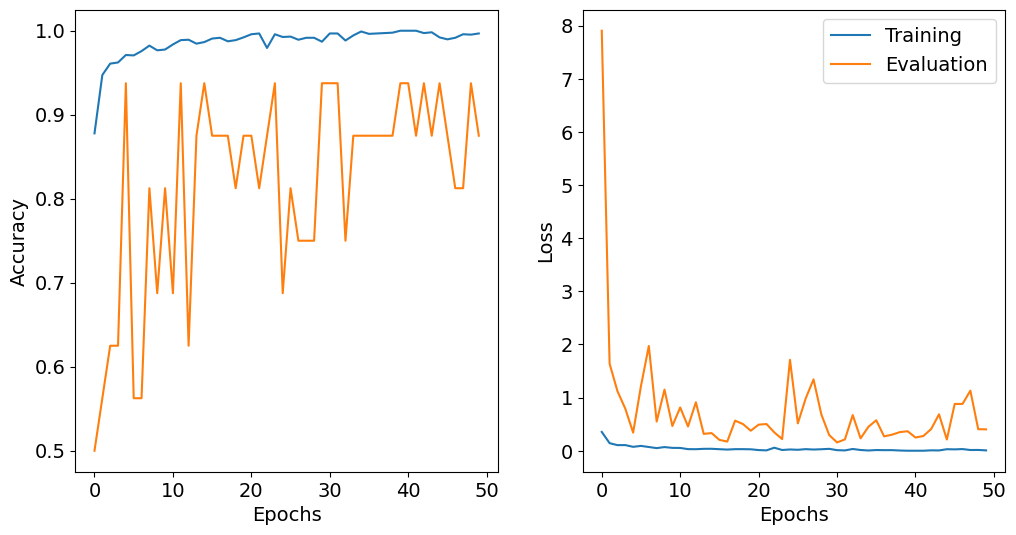

In [ ]:
plot_result(
  num_epochs,
  metrics_model['train_accuracy'], metrics_model['valid_accuracy'],
  metrics_model['train_loss'], metrics_model['valid_loss']
)

In [ ]:
summary(model, (1, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             320
       BatchNorm2d-2         [-1, 32, 150, 150]              64
         MaxPool2d-3           [-1, 32, 76, 76]               0
            Conv2d-4           [-1, 64, 76, 76]          18,496
           Dropout-5           [-1, 64, 76, 76]               0
       BatchNorm2d-6           [-1, 64, 76, 76]             128
         MaxPool2d-7           [-1, 64, 39, 39]               0
            Conv2d-8           [-1, 64, 39, 39]          36,928
       BatchNorm2d-9           [-1, 64, 39, 39]             128
        MaxPool2d-10           [-1, 64, 20, 20]               0
           Conv2d-11          [-1, 128, 20, 20]          73,856
          Dropout-12          [-1, 128, 20, 20]               0
      BatchNorm2d-13          [-1, 128, 20, 20]             256
        MaxPool2d-14          [-1, 128,

## Fine tuning with Ray Tune:

In [ ]:
!pip install -q ray

In [ ]:
import ray
from ray import tune, train
from functools import partial

In [ ]:
# evaluate model
def evaluate_model_for_tuning(config, model_state_dict, valid_dataloader):
  # Initialize the model
  model = CustomCNNModel(num_classes=config["classes"])

  # Update the model's state dictionary
  model.load_state_dict(state_dict)

  criterion = torch.nn.CrossEntropyLoss()

  # GPU available?
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  print(f"Using: {device}")
  model = model.to(device)

  accs, losses = [], []

  with torch.no_grad():
    for index, (inputs, labels) in enumerate(valid_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = model(inputs)

      loss = criterion(predictions, labels)
      losses.append(loss.item())

      total_acc = (predictions.argmax(1) == labels).sum().item()
      acc = total_acc / labels.size(0)
      accs.append(acc)

  model_acc = sum(accs) / len(accs)
  model_loss = sum(losses) / len(losses)

  train.report({"loss": model_loss, "accuracy": model_acc})

In [ ]:
# Check available GPU
gpu = cuda.is_available()
print('GPU is available: {}'.format(gpu))

if gpu:
  gpu_count = cuda.device_count()
  print('{} GPUs detected.'.format(gpu_count))
  if gpu_count > 1:
    multi_gpu = True
  else:
    multi_gpu = False

GPU is available: True
1 GPUs detected.


In [ ]:
config = {
    "classes": 2,
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32, 64, 128]),
}

# Load the state dictionary
model_path = os.path.join(dir_path, 'model', 'model_01_best.pt')
state_dict = torch.load(model_path)

# Initialize Ray
ray.init(num_gpus=gpu_count)

# Pass the new function to tune.run()
analysis = tune.run(
    partial(evaluate_model_for_tuning, model_state_dict=state_dict, valid_dataloader=valid_loader),
    config=config,
    num_samples=10,
    resources_per_trial={"cpu": 2, "gpu": 1},
    metric="accuracy",
    mode="max"
)

print("Best hyperparameters found were: ", analysis.best_config)

# Shutdown Ray
ray.shutdown()

2024-01-03 17:00:49,366	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-03 17:00:51,344	INFO tune.py:592 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-01-03 17:00:51,539	INFO tensorboardx.py:178 -- pip install "ray[tune]" to see TensorBoard files.
2024-01-03 17:00:51,540	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


+----------------------------------------------------------------------------------+
| Configuration for experiment     evaluate_model_for_tuning_2024-01-03_17-00-51   |
+----------------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                           |
| Scheduler                        FIFOScheduler                                   |
| Number of trials                 10                                              |
+----------------------------------------------------------------------------------+

View detailed results here: /root/ray_results/evaluate_model_for_tuning_2024-01-03_17-00-51

Trial status: 10 PENDING
Current time: 2024-01-03 17:00:52. Total running time: 1s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+-------------------------------------------------------------------------------+
| Trial name                              status              lr     batc

(func pid=23211) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=23211)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00000 finished iteration 1 at 2024-01-03 17:01:15. Total running time: 23s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00000 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       5.49336 |
| time_total_s                                           5.49336 |
| training_iteration                                           1 |
| accuracy                                               0.78594 |
| loss                                                   0.84835 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00000 completed after 1 iterations at 2024-01-03 17:01:15. Total running time: 23s

Trial evaluate_model_for_tuning_a661b_00001 started with configuration:
+--------------------

(func pid=23365) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=23365)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial status: 1 TERMINATED | 1 RUNNING | 8 PENDING
Current time: 2024-01-03 17:01:22. Total running time: 31s
Logical resource usage: 2.0/2 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: a661b_00000 with accuracy=0.7859375 and params={'classes': 2, 'lr': 0.007313745412579899, 'batch_size': 16}
+-------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                              status                lr     batch_size     iter     total time (s)       loss     accuracy |
+-------------------------------------------------------------------------------------------------------------------------------------+
| evaluate_model_for_tuning_a661b_00001   RUNNING      0.0174897              128                                                     |
| evaluate_model_for_tuning_a661b_00000   TERMINATED   0.00731375              16        1            5.49336   0.848353     0.785937 |
| ev

(func pid=23460) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=23460)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00002 finished iteration 1 at 2024-01-03 17:01:33. Total running time: 42s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00002 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       3.12466 |
| time_total_s                                           3.12466 |
| training_iteration                                           1 |
| accuracy                                               0.79375 |
| loss                                                   0.96373 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00002 completed after 1 iterations at 2024-01-03 17:01:33. Total running time: 42s

Trial evaluate_model_for_tuning_a661b_00003 started with configuration:
+--------------------

(func pid=23558) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=23558)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00003 finished iteration 1 at 2024-01-03 17:01:41. Total running time: 50s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00003 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       2.19449 |
| time_total_s                                           2.19449 |
| training_iteration                                           1 |
| accuracy                                               0.77969 |
| loss                                                   0.98639 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00003 completed after 1 iterations at 2024-01-03 17:01:41. Total running time: 50s

Trial evaluate_model_for_tuning_a661b_00004 started with configuration:
+--------------------

(func pid=23645) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=23645)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00004 finished iteration 1 at 2024-01-03 17:01:51. Total running time: 59s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00004 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       2.20511 |
| time_total_s                                           2.20511 |
| training_iteration                                           1 |
| accuracy                                               0.77187 |
| loss                                                   1.02714 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00004 completed after 1 iterations at 2024-01-03 17:01:51. Total running time: 59s

Trial status: 5 TERMINATED | 5 PENDING
Current time: 2024-01-03 17:01:52. Total running time:

(func pid=23745) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=23745)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00005 finished iteration 1 at 2024-01-03 17:02:00. Total running time: 1min 8s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00005 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       2.46423 |
| time_total_s                                           2.46423 |
| training_iteration                                           1 |
| accuracy                                               0.80156 |
| loss                                                   1.01899 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00005 completed after 1 iterations at 2024-01-03 17:02:00. Total running time: 1min 8s

Trial evaluate_model_for_tuning_a661b_00006 started with configuration:
+------------

(func pid=23835) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=23835)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00006 finished iteration 1 at 2024-01-03 17:02:10. Total running time: 1min 18s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00006 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       2.21472 |
| time_total_s                                           2.21472 |
| training_iteration                                           1 |
| accuracy                                               0.78125 |
| loss                                                    0.8857 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00006 completed after 1 iterations at 2024-01-03 17:02:10. Total running time: 1min 18s

Trial evaluate_model_for_tuning_a661b_00007 started with configuration:
+----------

(func pid=23934) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=23934)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00007 finished iteration 1 at 2024-01-03 17:02:22. Total running time: 1min 30s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00007 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       6.28327 |
| time_total_s                                           6.28327 |
| training_iteration                                           1 |
| accuracy                                               0.78906 |
| loss                                                   0.93935 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00007 completed after 1 iterations at 2024-01-03 17:02:22. Total running time: 1min 30s

Trial status: 8 TERMINATED | 2 PENDING
Current time: 2024-01-03 17:02:22. Total run

(func pid=24043) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=24043)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00008 finished iteration 1 at 2024-01-03 17:02:30. Total running time: 1min 38s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00008 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       2.34568 |
| time_total_s                                           2.34568 |
| training_iteration                                           1 |
| accuracy                                               0.80156 |
| loss                                                   0.86828 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00008 completed after 1 iterations at 2024-01-03 17:02:30. Total running time: 1min 38s

Trial evaluate_model_for_tuning_a661b_00009 started with configuration:
+----------

(func pid=24134) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
(func pid=24134)   warnings.warn('Lazy modules are a new feature under heavy development '



Trial evaluate_model_for_tuning_a661b_00009 finished iteration 1 at 2024-01-03 17:02:40. Total running time: 1min 49s
+----------------------------------------------------------------+
| Trial evaluate_model_for_tuning_a661b_00009 result             |
+----------------------------------------------------------------+
| checkpoint_dir_name                                            |
| time_this_iter_s                                       2.17542 |
| time_total_s                                           2.17542 |
| training_iteration                                           1 |
| accuracy                                               0.80312 |
| loss                                                   0.98745 |
+----------------------------------------------------------------+

Trial evaluate_model_for_tuning_a661b_00009 completed after 1 iterations at 2024-01-03 17:02:40. Total running time: 1min 49s

Trial status: 10 TERMINATED
Current time: 2024-01-03 17:02:40. Total running time: 

## Re-train the model using fine-tuned hyperparameters

In [ ]:
tuned_lr = analysis.best_config["lr"]
tuned_batch_size = analysis.best_config["batch_size"]

In [ ]:
tuned_train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=tuned_batch_size,
                                           shuffle=True,
                                           drop_last=False)

In [ ]:
num_classes = len(train_dataset.classes)

# GPU available?
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

model = CustomCNNModel(num_classes)
# we can wrap our model in nn.DataParallel to support data parallel training on multiple GPUs if available
if multi_gpu:
  model = nn.DataParallel(model)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=tuned_lr)

num_epochs = 50
save_model_folder = 'model'
os.makedirs(save_model_folder, exist_ok=True)
tuned_model_name = 'model_tuned.pt'
# model_name = 'model_02_best.pt'
save_model_dir = os.path.join(save_model_folder, model_name)

tuned_model, tuned_metrics_model = train(
    model, save_model_dir,
    optimizer, criterion,
    tuned_train_loader, valid_loader,
    num_epochs,
    device
)

Using: cuda
Epoch:   1 |     5/  133 batches | accuracy    0.781
Epoch:   1 |    10/  133 batches | accuracy    0.835
Epoch:   1 |    15/  133 batches | accuracy    0.863
Epoch:   1 |    20/  133 batches | accuracy    0.872
Epoch:   1 |    25/  133 batches | accuracy    0.873
Epoch:   1 |    30/  133 batches | accuracy    0.881
Epoch:   1 |    35/  133 batches | accuracy    0.884
Epoch:   1 |    40/  133 batches | accuracy    0.890
Epoch:   1 |    45/  133 batches | accuracy    0.890
Epoch:   1 |    50/  133 batches | accuracy    0.896
Epoch:   1 |    55/  133 batches | accuracy    0.898
Epoch:   1 |    60/  133 batches | accuracy    0.900
Epoch:   1 |    65/  133 batches | accuracy    0.903
Epoch:   1 |    70/  133 batches | accuracy    0.909
Epoch:   1 |    75/  133 batches | accuracy    0.909
Epoch:   1 |    80/  133 batches | accuracy    0.910
Epoch:   1 |    85/  133 batches | accuracy    0.910
Epoch:   1 |    90/  133 batches | accuracy    0.908
Epoch:   1 |    95/  133 batches |

### Plot training result

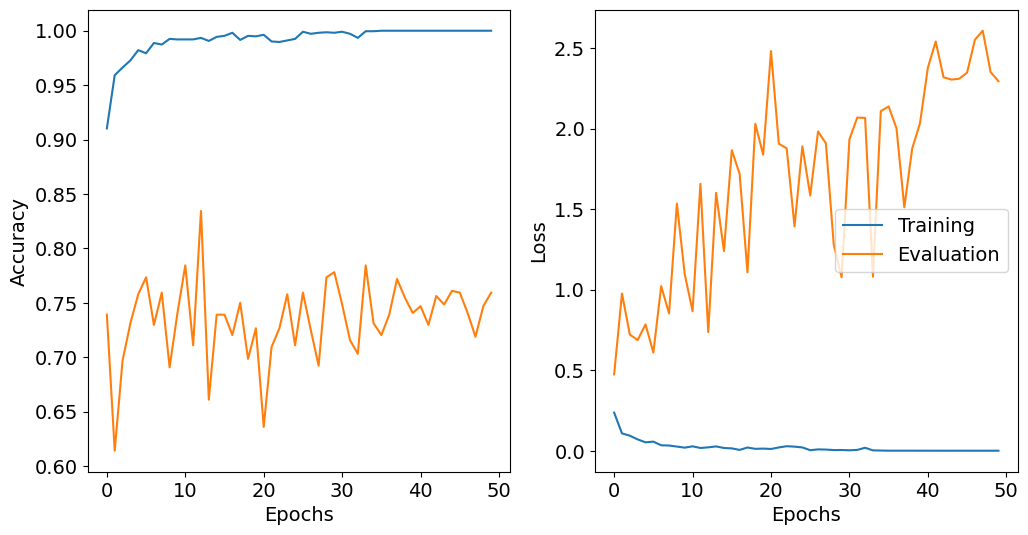

In [ ]:
plot_result(
  num_epochs,
  tuned_metrics_model['train_accuracy'], tuned_metrics_model['valid_accuracy'],
  tuned_metrics_model['train_loss'], tuned_metrics_model['valid_loss']
)

In [ ]:
summary(tuned_model, (1, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 150, 150]             320
       BatchNorm2d-2         [-1, 32, 150, 150]              64
         MaxPool2d-3           [-1, 32, 76, 76]               0
            Conv2d-4           [-1, 64, 76, 76]          18,496
           Dropout-5           [-1, 64, 76, 76]               0
       BatchNorm2d-6           [-1, 64, 76, 76]             128
         MaxPool2d-7           [-1, 64, 39, 39]               0
            Conv2d-8           [-1, 64, 39, 39]          36,928
       BatchNorm2d-9           [-1, 64, 39, 39]             128
        MaxPool2d-10           [-1, 64, 20, 20]               0
           Conv2d-11          [-1, 128, 20, 20]          73,856
          Dropout-12          [-1, 128, 20, 20]               0
      BatchNorm2d-13          [-1, 128, 20, 20]             256
        MaxPool2d-14          [-1, 128,

### So after tuning with Ray Tune, the model becomes worse and overfitting!!! I don't understand :D